In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import importlib

import itertools
import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models
import helpers, opt, objectives

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [26]:
with open('../inputs/phoq.pkl', 'rb') as f:
    t = pickle.load(f)
X = t[0]
A = t[2]
y = t[3].values
wt = helpers.decode_X(X[150614])  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'
n_aas = 20

ground = [(aa, i) for aa in aas for i in range(4)]
L = 4

seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i
wt_inds = [seq_to_x[wt]]

In [10]:
np.random.seed(120120)
_ = torch.manual_seed(43298)



n = 100

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
train_inds = wt_inds + single_inds + list(np.random.choice(len(X), n, replace=True))


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

inds = sorted(set(train_inds))
print(len(inds))
dic, _, mo = helpers.get_predictions(A[inds], y[inds], A_test,
                                 one_hots=X, its=3000, lr=1e-2,
                                return_model=True)
print()
seen_seqs = [helpers.decode_X(X[i]) for i in inds]
for s in seen_seqs:
    dic[s] = 0.0

177
Iteration 3000 of 3000	NLML: 58.9343	sn: 0.259592	


In [11]:
seed = helpers.get_seed(dic)
X_list, objs_list = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))

np.random.seed(34876)
M = [[int(np.random.random() * 6 + 1) for _ in range(L)] for _ in range(10)]
inds = [[np.random.choice(n_aas, m, replace=False) * 4 + i for i, m in enumerate(mm)] for mm in M]
inds = [list(itertools.chain.from_iterable(ind)) for ind in inds]
X_list += [[ground[i] for i in lib] for lib in inds]


X_list += [X_list[9] + lib for lib in libs]

np.random.seed(34876)
M = [[int(np.random.random() * 2 + 1) for _ in range(L)] for _ in range(10)]
inds = [[np.random.choice(n_aas, m, replace=False) * 4 + i for i, m in enumerate(mm)] for mm in M]
inds = [list(itertools.chain.from_iterable(ind)) for ind in inds]
libs = [[ground[i] for i in lib] for lib in inds]
X_list += [X_list[12] + lib for lib in libs]


X_list = [sorted(set(x)) for x in X_list]

for lib in X_list:
    print(helpers.get_N(lib, L))
appro = [objectives.objective(lib, L, dic, n).item() for lib in X_list]

    
appro

1
2
4
8
16
24
36
54
72
96
120
144
168
192
96
90
12
288
80
24
80
540
360
12
450
540
480
840
525
576
576
768
540
525


[-0.17123523886021352,
 -0.3308861365275758,
 -0.6190653958052903,
 -1.056581439519559,
 -1.7163896510374819,
 -2.4658695507553645,
 -3.365414006318751,
 -4.189944208233536,
 -4.860962439587918,
 -5.303562711767881,
 -5.595809790727419,
 -5.708489296885209,
 -5.778486512129778,
 -5.808614691346905,
 -0.3018007394019666,
 -0.05454708071439159,
 -0.0011676829836103186,
 -0.093178164262071,
 -0.2704720931118698,
 -0.015413600705468943,
 -0.17649418821133517,
 -0.40268676301894557,
 -0.38644480227646794,
 -0.0047139986993020916,
 -3.463222761485041,
 -3.1541896679810075,
 -3.387690631160524,
 -2.274435701083717,
 -3.424816823442821,
 -3.946726320576566,
 -2.9094821660743215,
 -3.314520517278918,
 -3.406405842332739,
 -3.1097626879706626]

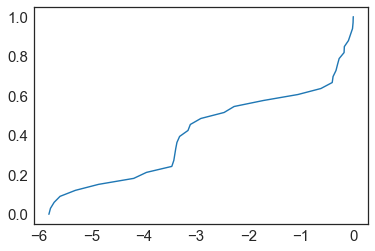

In [15]:
_ = plt.plot(np.sort(appro), np.linspace(0, 1, len(appro)))

In [18]:
%%time 
objectives = importlib.reload(objectives)
observed = seen_seqs
tau = max((y - np.mean(y)) / np.std(y))
X_all = A
its = 10000
np.random.seed(129)
_ = torch.manual_seed(450)


    
results = [objectives.sample_obj(lib, mo, tau, seq_to_x, X_all, observed=observed, its=its,
                                      n=n, return_all=True)
           for lib in X_list]
samples = [result[1].detach().numpy() for result in results]

CPU times: user 4min 6s, sys: 2.92 s, total: 4min 9s
Wall time: 4min 40s


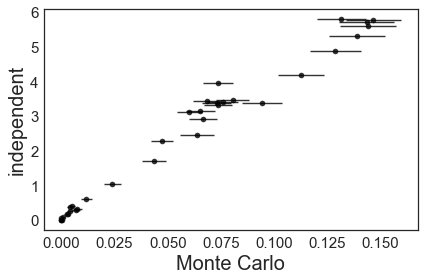

In [23]:
for ap, sa in zip(appro, samples):
    SE = sa.std() / np.sqrt(its)
    _ = plt.errorbar(sa.mean(), -ap, xerr=2*SE, fmt='o', alpha=0.8, color='black')
_ = plt.xlabel('Monte Carlo')
_ = plt.ylabel('independent')
_ = plt.tight_layout()
_ = plt.savefig('../outputs/objectives_comparison.pdf')

In [20]:
results = {
    'indpt': appro,
    'mc': samples, 
    'mo': mo, 
    'X_list': X_list
}
with open('../outputs/20181003_phoq_objectives.pkl', 'wb') as f:
    pickle.dump(results, f)

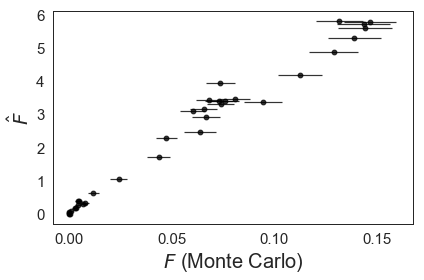

In [5]:
with open('../outputs/20181003_phoq_objectives.pkl', 'rb') as f:
    results = pickle.load(f)
    
appro = results['indpt']
samples = results['mc']
its = 10000
for ap, sa in zip(appro, samples):
    SE = sa.std() / np.sqrt(its)
    _ = plt.errorbar(sa.mean(), -ap, xerr=2*SE, fmt='o', alpha=0.8, color='black')
_ = plt.ylabel(r'$\hat{F}$')
_ = plt.xlabel(r'$F$ (Monte Carlo)')
_ = plt.tight_layout()
_ = plt.savefig('../outputs/objectives_comparison.pdf')

In [7]:
with open('../inputs/gb1.pkl', 'rb') as f:
    t = pickle.load(f)
X = t[0]
A = t[1]
y = t[2]
wt = t[3]

aas = 'ARNDCQEGHILKMFPSTWYV'

ground = [(aa, i) for aa in aas for i in range(4)]
L = 4

seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i
wt_inds = [seq_to_x[wt]]

np.random.seed(125120)
_ = torch.manual_seed(43298)


n = 100

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
wt_inds = [seq_to_x[wt]]
single_inds = wt_inds + [seq_to_x[seq] for seq in singles]
train_inds = wt_inds + single_inds + list(np.random.choice(len(X), n, replace=True))


y_true = y
A_test = A

sampled_inds = [train_inds[:]]
libs = []
objs = []

inds = sorted(set(train_inds))
print(len(inds))
dic, _, mo = helpers.get_predictions(A[inds], y[inds], A_test,
                                 one_hots=X, its=3000, lr=1e-2,
                                return_model=True)
print()
seen_seqs = [helpers.decode_X(X[i]) for i in inds]
for s in seen_seqs:
    dic[s] = 0.0

177
Iteration 3000 of 3000	NLML: 79.2391	sn: 0.396256	


In [8]:
seed = helpers.get_seed(dic)
n_aas = len(aas)
X_list, objs_list = opt.greedy(ground, seed, objectives.objective, depth=1, obj_args=(L, dic, n))

np.random.seed(34876)
M = [[int(np.random.random() * 6 + 1) for _ in range(L)] for _ in range(10)]
inds = [[np.random.choice(n_aas, m, replace=False) * 4 + i for i, m in enumerate(mm)] for mm in M]
inds = [list(itertools.chain.from_iterable(ind)) for ind in inds]
X_list += [[ground[i] for i in lib] for lib in inds]


X_list += [X_list[9] + lib for lib in libs]

np.random.seed(34876)
M = [[int(np.random.random() * 2 + 1) for _ in range(L)] for _ in range(10)]
inds = [[np.random.choice(n_aas, m, replace=False) * 4 + i for i, m in enumerate(mm)] for mm in M]
inds = [list(itertools.chain.from_iterable(ind)) for ind in inds]
libs = [[ground[i] for i in lib] for lib in inds]
X_list += [X_list[12] + lib for lib in libs]


X_list = [sorted(set(x)) for x in X_list]

for lib in X_list:
    print(helpers.get_N(lib, L))
appro = [objectives.objective(lib, L, dic, n).item() for lib in X_list]

    
appro

1
2
3
6
12
18
24
48
64
80
100
50
60
70
80
90
96
90
12
288
80
24
80
540
360
12
336
432
324
294
294
180
441
504
504
252


[-0.009983847351611508,
 -0.01917757534828235,
 -0.02766716469566599,
 -0.03975195552865445,
 -0.0524411869612902,
 -0.06936191611865827,
 -0.08853932757657655,
 -0.1060576537756758,
 -0.11730616938487036,
 -0.1252879910566958,
 -0.12877721965303845,
 -0.13207888362549253,
 -0.14005768706622657,
 -0.14609898350257047,
 -0.14982228786870755,
 -0.15035275133914447,
 -0.0020265196853452338,
 -0.010308500614800006,
 -0.00018483873348526498,
 -0.0061208271010297485,
 -0.007780827343324811,
 -0.006038134511697642,
 -0.0008723301502860032,
 -0.006586355390336358,
 -0.008260417179494741,
 -0.001515411635598095,
 -0.0590133028013327,
 -0.06116613992404697,
 -0.06776581915793639,
 -0.07473138595299003,
 -0.09141671902657113,
 -0.092445423111988,
 -0.04967925349865195,
 -0.05174046299815473,
 -0.05886410700888602,
 -0.08654458268081143]

In [9]:
%%time 
objectives = importlib.reload(objectives)
observed = seen_seqs
tau = max((y - np.mean(y)) / np.std(y))
X_all = A
its = 10000
np.random.seed(129)
_ = torch.manual_seed(450)


    
results = [objectives.sample_obj(lib, mo, tau, seq_to_x, X_all, observed=observed, its=its,
                                      n=n, return_all=True)
           for lib in X_list]
samples = [result[1].detach().numpy() for result in results]

CPU times: user 2min 4s, sys: 1.01 s, total: 2min 5s
Wall time: 2min 5s


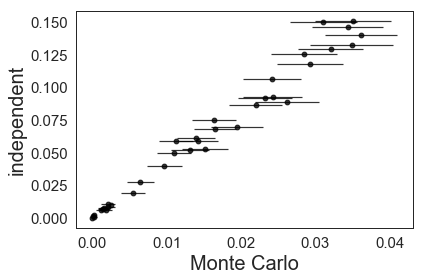

In [10]:
for ap, sa in zip(appro, samples):
    SE = sa.std() / np.sqrt(its)
    _ = plt.errorbar(sa.mean(), -ap, xerr=2*SE, fmt='o', alpha=0.8, color='black')
_ = plt.xlabel('Monte Carlo')
_ = plt.ylabel('independent')
_ = plt.tight_layout()
_ = plt.savefig('../outputs/gb1_objectives_comparison.pdf')

In [11]:
results = {
    'indpt': appro,
    'mc': samples, 
    'mo': mo, 
    'X_list': X_list
}
with open('../outputs/20181018_gb1_objectives.pkl', 'wb') as f:
    pickle.dump(results, f)

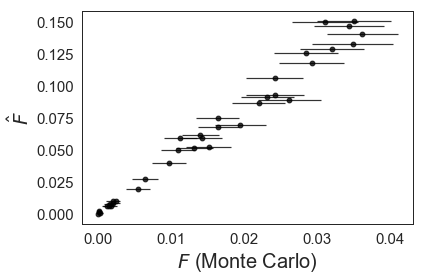

In [6]:
with open('../outputs/20181018_gb1_objectives.pkl', 'rb') as f:
    results = pickle.load(f)
    
appro = results['indpt']
samples = results['mc']
its = 10000
for ap, sa in zip(appro, samples):
    SE = sa.std() / np.sqrt(its)
    _ = plt.errorbar(sa.mean(), -ap, xerr=2*SE, fmt='o', alpha=0.8, color='black')
_ = plt.ylabel(r'$\hat{F}$')
_ = plt.xlabel(r'$F$ (Monte Carlo)')
_ = plt.tight_layout()
_ = plt.savefig('../outputs/gb1_objectives_comparison.pdf')